# Library Imports

In [1]:
!pip install pydicom

In [2]:
import pandas as pd
import numpy as np
import pydicom
from glob2 import glob
import glob2
from tqdm import tqdm
import shutil
import os
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import warnings
from joblib import Parallel, delayed
warnings.filterwarnings("ignore")
from keras import backend as K

# Download Dataset and Extract

In [3]:
# https://gist.github.com/jayspeidell/d10b84b8d3da52df723beacc5b15cb27
!mkdir -p '/root/.kaggle/'
!cp '/content/kaggle.json' '/root/.kaggle/kaggle.json'
# !touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d seesee/siim-train-test

100% 1.92G/1.92G [00:18<00:00, 38.7MB/s]
100% 1.92G/1.92G [00:18<00:00, 110MB/s] 


In [5]:
print("Extracting 'siim-train-test.zip'\n")
!unzip -qq '/content/siim-train-test.zip'
print("Done Extracting 'siim-train-test.zip'")

Extracting 'siim-train-test.zip'

Done Extracting 'siim-train-test.zip'


# Move files

In [6]:
# Create Directories to move files
destination_1 = 'siim/train_dicom'

if not os.path.isdir(destination_1):
    os.makedirs(destination_1)

def move_files(source, destination):
    '''
    This function takes source and destination paths as input 
    and moves files from source to the destination folder.
    '''
    print(source)
    for filename in tqdm(glob2.glob(source)):
        shutil.move(str(filename), destination)

train_path = 'siim/dicom-images-train/**/*.dcm'

move_files(train_path, destination_1)

siim/dicom-images-train/**/*.dcm


100%|██████████| 12089/12089 [00:00<00:00, 22406.32it/s]


# Prepocessing

## PNG Conversion

We have the files in the form of **.dcm** files, we cannot use them directly for training the model. So we have to convert them into **.png** format. Also I have to create masks for respective images which also be in **.png** format. 

So let's start,

In [18]:
train_data = pd.read_csv('train_images_dicom.csv')
train_data.head(2)

,ImageId,EncodedPixels,ImagePath
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,siim/train_dicom/1.2.276.0.7230010.3.1.4.83233...
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,siim/train_dicom/1.2.276.0.7230010.3.1.4.83233...


In [9]:
# from skimage import exposure
def convert_to_png(filename):
    """
    filename : filename with extension '.dcm' with it's full path
    'This function creates png images from the dicom files'
    """
    # read dicom file
    ds = pydicom.read_file(str(filename))
    # convert dicom image to array
    img = ds.pixel_array
    # resize the image for fast computation
    img = cv2.resize(img, (256, 256))
    # create new file name
    fname = filename.replace(".dcm", ".png")
    fname = fname.replace("_dicom", "_png")
    # save the png image to disk
    cv2.imwrite(fname, img)

In [10]:
# Create Directories for png files
destination_1 = 'siim/train_png'

if not os.path.isdir(destination_1):
    os.makedirs(destination_1)

In [11]:
train_conversion = Parallel(n_jobs=-1, backend='threading')(delayed(
                            convert_to_png)(file) for file in tqdm(train_data['ImagePath'], 
                                                     total=len(train_data['ImagePath'])))

100%|██████████| 12047/12047 [01:30<00:00, 132.80it/s]


In [12]:
print(os.listdir('siim/train_png/')[0])

1.2.276.0.7230010.3.1.4.8323329.13619.1517875246.877085.png


## Mask Creation

In [14]:
def rle2mask(rle, width, height):
    """
    RLE to mask conversion provided by competetion organizers with the dataset.
    """
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [15]:
# Create Directories for mask png files
destination_1 = 'siim/train_mask_png'

if not os.path.isdir(destination_1):
    os.makedirs(destination_1)

In [16]:
def get_masks(data, destination):
    """
    data : DataFrame with Columns 'ImageId' and ' EncodedPixels'
    destination: Path for saving masks
    """
    print("\nCreating masks...")
    # for each image in the data
    for Id,pix in tqdm(data.values):
        # create filename for mask image
        fname = f"{destination}{Id}.png" #_mask
        # check if the encoding present
        # if present then decode the mask using rle2mask(rle, width, height) function
        if pix!= "-1":
            mask = rle2mask(pix, 1024, 1024).T
            # resize for fast computation
            mask = cv2.resize(mask, (256, 256))
            cv2.imwrite(fname, mask)
        else:
            mask = np.zeros((256, 256), dtype=np.uint8)
            cv2.imwrite(fname, mask)
    print("\nDone!")


# path for saving mask images
train_mask_path = 'siim/train_mask_png/'
# call the function for creating masks
get_masks(train_data[['ImageId', ' EncodedPixels']], train_mask_path)

  0%|          | 0/12047 [00:00<?, ?it/s]


Creating masks...


100%|██████████| 12047/12047 [00:19<00:00, 602.91it/s]


Done!


# Read CSV

In [3]:
final_data = pd.read_csv('final_data.csv')
final_data.head()

,ImagePath,MaskPath
0,siim/train_png/1.2.276.0.7230010.3.1.4.8323329...,siim/train_mask_png/1.2.276.0.7230010.3.1.4.83...
1,siim/train_png/1.2.276.0.7230010.3.1.4.8323329...,siim/train_mask_png/1.2.276.0.7230010.3.1.4.83...
2,siim/train_png/1.2.276.0.7230010.3.1.4.8323329...,siim/train_mask_png/1.2.276.0.7230010.3.1.4.83...
3,siim/train_png/1.2.276.0.7230010.3.1.4.8323329...,siim/train_mask_png/1.2.276.0.7230010.3.1.4.83...
4,siim/train_png/1.2.276.0.7230010.3.1.4.8323329...,siim/train_mask_png/1.2.276.0.7230010.3.1.4.83...


# Define Double UNet model

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = 1
    filters = init.shape[channel_axis]
    se_shape = (filters, 1, 1)

    se = GlobalAveragePooling2D(data_format='channels_first')(init)
    # se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = Reshape(se_shape)(se)
    print(se.shape)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same",data_format='channels_first')(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same",data_format='channels_first')(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs, input_shape=(3,256,256))
    # names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    names = [ "block1_conv2", "block2_conv2"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    # output = model.get_layer("block5_conv4").output
    output = model.get_layer("block3_conv4").output
    # print("<<VGG19")
    # for v in range(len(skip_connections)):
    #     print(skip_connections[v].shape)
    # print("VGG19>>")
    return output, skip_connections

def decoder1(inputs, skip_connections):
    # num_filters = [256, 128, 64, 32]
    num_filters = [64, 32]
    skip_connections.reverse()
    
    x = inputs

    for i, f in enumerate(num_filters):
        # x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = UpSampling2D((2, 2), interpolation='bilinear',data_format='channels_first')(x)
        # print(x.shape, skip_connections[i].shape)
        x = Concatenate(axis=1)([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

# def encoder2(inputs):
#     skip_connections = []
#
#     output = DenseNet121(include_top=False, weights='imagenet')(inputs)
#     model = tf.keras.models.Model(inputs, output)
#
#     names = ["input_2", "conv1/relu", "pool2_conv", "pool3_conv"]
#     for name in names:
#         skip_connections.append(model.get_layer(name).output)
#     output = model.get_layer("pool4_conv").output
#
#     return output, skip_connections

def encoder2(inputs):
    # num_filters = [32, 64, 128, 256]
    num_filters = [32, 64]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2),data_format='channels_first')(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    # num_filters = [256, 128, 64, 32]
    num_filters = [256, 128]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear',data_format='channels_first')(x)
        x = Concatenate(axis=1)([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same",data_format='channels_first')(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[2], shape[3]),data_format='channels_first')(x)
    y1 = Conv2D(filter, 1, padding="same",data_format='channels_first')(y1)
    y1 = BatchNormalization(axis=1)(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[2], shape[3]), interpolation='bilinear',data_format='channels_first')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False,data_format='channels_first')(x)
    y2 = BatchNormalization(axis=1)(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False,data_format='channels_first')(x)
    y3 = BatchNormalization(axis=1)(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False,data_format='channels_first')(x)
    y4 = BatchNormalization(axis=1)(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False,data_format='channels_first')(x)
    y5 = BatchNormalization(axis=1)(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate(axis=1)([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False,data_format='channels_first')(y)
    y = BatchNormalization(axis=1)(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate(axis=1)([outputs1, outputs2])

    model = Model(inputs, outputs)
    return model
# inp_shape = (256,256,3)
# model = build_model(inp_shape)

In [5]:
# K.set_image_data_format('channels_last')
K.set_image_data_format('channels_first')
inp_shape = (3,256,256)
model = build_model(inp_shape)
model.summary()

(None, 64, 1, 1)
(None, 32, 1, 1)
(None, 32, 1, 1)
(None, 64, 1, 1)
(None, 256, 1, 1)
(None, 128, 1, 1)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 256, 256) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 256, 256) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 256, 256) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 128, 128) 0           block1_conv2[0][0

In [6]:
model.inputs, model.outputs

([<tf.Tensor 'input_1:0' shape=(None, 3, 256, 256) dtype=float32>],
 [<tf.Tensor 'concatenate_6/concat:0' shape=(None, 2, 256, 256) dtype=float32>])

# Final Inference

In [7]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
def read_image(path):
    """
    This reads image 
    ----------------
    path : image path
    ----------------
    """

    x = tf.io.read_file(path)
    x = tf.image.decode_png(x, channels=3)
    x = tf.image.convert_image_dtype(x, tf.float32)
    # x = x / 255.0
    # x = tf.image.convert_image_dtype(x, tf.float32)

    return x

def read_mask(path):
    """
    This reads mask 
    ----------------
    path : mask path
    ----------------
    """
    y = tf.io.read_file(path)
    y = tf.image.decode_png(y, channels=1)
    y = tf.image.convert_image_dtype(y, tf.float32)
    # y = y / 255.0
    # y = tf.image.convert_image_dtype(y, tf.float32)
    return y


In [9]:
def Predict(model, image_path, plot=True):
    """
    This function predicts the mask for given input image and plots it.
    ------------------------------------------------------------------
    model      : saved model path
    image_path : image path 
    plot       : Boolean (True or False)

    if plot is True then plots the image with predicted mask if False returns predicted mask array
    ------------------------------------------------------------------
    """
    # read the original image
    image_orig = read_image(image_path)
    # reshape image and mask as first channel image format
    image = tf.transpose(image_orig, [2,0,1])
    # predict the mask using trained model
    predict_mask = model.predict(tf.expand_dims(image, axis=0))
    predict_mask = tf.transpose(predict_mask, [0,2,3,1])
    if plot == True:
        plt.imshow(image_orig)      
        plt.imshow(np.squeeze(predict_mask[:,:,:,1]), cmap='Reds', alpha = 0.3)
    # if plot == Falsereturn the predicted mask 
    else:
        return predict_mask

In [10]:
# load the saved model
model.load_weights( '/content/drive/MyDrive/27_Case_study_2/best_Double_Unet.hdf5')
print("Loaded model...{best_Double_Unet.hdf5}")

Loaded model...{best_Double_Unet.hdf5}


3700


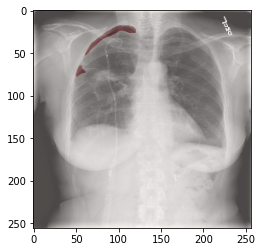

In [16]:
rand_id = np.random.randint(len(final_data))
print(rand_id)
image_path = final_data['ImagePath'].values[rand_id]
Predict(model, image_path, plot=True)

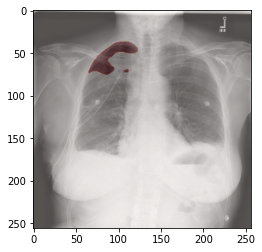

In [40]:
rand_id = np.random.randint(len(final_data))
print(rand_id)
image_path = final_data['ImagePath'].values[rand_id]
Predict(model, image_path, plot=True)

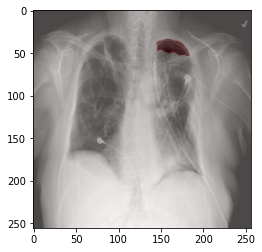

In [44]:
rand_id = np.random.randint(len(final_data))
print(rand_id)
image_path = final_data['ImagePath'].values[rand_id]
Predict(model, image_path, plot=True)

11375


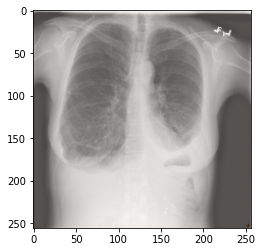

In [46]:
rand_id = np.random.randint(len(final_data))
image_path = final_data['ImagePath'].values[rand_id]
print(rand_id)
Predict(model, image_path, plot=True)

In [47]:
train_data[' EncodedPixels'].values[11375]

'-1'